In [502]:
from pathlib import Path
from glob import glob
import re
import pandas as pd

In [503]:

test_train_splits = [{"train": 0, "test": 0} for _ in range(5)]

for file in glob("../data/test_train_split/*.feather"):
    file_name = re.split("\\\\|/", file)[-1]
    test_train, split = file_name.split(".")[0].split("_")

    test_train_splits[int(split)][test_train] = pd.read_feather(file)

# FIXME: For the sake of this example, we feature engineer a trend (This should really be done in test_train)
MIN_DATE = test_train_splits[0]["train"]["Date"].min()
MAX_DATE = test_train_splits[-1]["train"]["Date"].max()
for i in range(len(test_train_splits)):
    test_train_splits[i]["train"]["trend"] = (test_train_splits[i]["train"]["Date"] - MIN_DATE).dt.days / (MAX_DATE - MIN_DATE).days
    test_train_splits[i]["test"]["trend"] = (test_train_splits[i]["test"]["Date"] - MIN_DATE).dt.days / (MAX_DATE - MIN_DATE).days

test_train_splits[-1]["train"].head()

,Date,avgKWH,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,...,weekday cos,month sin,month cos,Time of Year sin,Time of Year cos,year,season sin,season cos,(-1)volume weighted price,trend
0,2011-11-26,10.267707,4.0,0.7,24.0,13.9,10.2,6.3,0.0,102580.0,...,-0.222521,-0.5,0.866025,-0.583054,0.812434,2011,1.224647e-16,-1.0,42.66,0.000000
1,2011-11-27,10.850805,3.0,5.9,55.0,13.2,11.8,9.7,0.0,102130.0,...,0.623490,-0.5,0.866025,-0.568992,0.822343,2011,1.224647e-16,-1.0,41.20,0.001458
2,2011-11-28,9.103382,5.0,0.0,15.0,13.9,6.7,0.2,0.0,102270.0,...,1.000000,-0.5,0.866025,-0.554762,0.832009,2011,1.224647e-16,-1.0,42.83,0.002915
3,2011-11-29,9.424468,6.0,0.0,15.0,12.8,8.6,3.3,0.4,100960.0,...,0.623490,-0.5,0.866025,-0.540368,0.841429,2011,1.224647e-16,-1.0,46.88,0.004373
4,2011-11-30,8.931027,4.0,3.7,42.0,11.0,9.2,5.5,1.2,101920.0,...,-0.222521,-0.5,0.866025,-0.525814,0.850600,2011,1.224647e-16,-1.0,42.69,0.005831


In [504]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from copy import deepcopy

SCALER_VARIABLES = ["(-1)volume weighted price", "cloud_cover", "sunshine", "global_radiation", "max_temp", "mean_temp", "min_temp", "precipitation", "pressure", "snow_depth", "days_elapsed", "(-1)avgKWH", "(-1)SMA3_avgKWH", "weekday sin", "weekday cos", "month sin", "month cos", "Time of Year sin", "Time of Year cos",
 "season sin", "season cos"]
DROP_VARIABLES = ["Date", "year"]
OUTPUT_VARIABLE = "avgKWH"

def do_transform(test_train_split, columns):
    train_df = test_train_split["train"].copy()
    train_df = train_df.drop(DROP_VARIABLES, axis=1)
    test_df = test_train_split["test"].copy()
    test_df = test_df.drop(DROP_VARIABLES, axis=1)

    scaler_encoders = []
    for scaler in SCALER_VARIABLES:
        encoder = StandardScaler()
        encoder.fit(train_df[scaler].values[:,np.newaxis])
        train_df[scaler] = encoder.transform(train_df[scaler].values[:,np.newaxis])
        test_df[scaler] = encoder.transform(test_df[scaler].values[:,np.newaxis])
        scaler_encoders.append(encoder)

    output_encoder = StandardScaler()
    output_encoder.fit(train_df[OUTPUT_VARIABLE].values[:, np.newaxis])
    train_df[OUTPUT_VARIABLE] = output_encoder.transform(train_df[OUTPUT_VARIABLE].values[:,np.newaxis])
    test_df[OUTPUT_VARIABLE] = output_encoder.transform(test_df[OUTPUT_VARIABLE].values[:,np.newaxis])

    train_x_df = train_df.drop(OUTPUT_VARIABLE, axis=1)
    # Only keep the columns we want
    if columns is not None:
        train_x_df = train_x_df[columns]

    test_train_split["train_x"] = train_x_df.to_numpy()
    test_train_split["train_y"] = train_df[OUTPUT_VARIABLE].to_numpy()
    
    test_x_df = test_df.drop(OUTPUT_VARIABLE, axis=1)
    # Only keep the columns we want
    if columns is not None:
        test_x_df = test_x_df[columns]

    test_train_split["test_x"] = test_x_df.to_numpy()
    test_train_split["test_y"] = test_df[OUTPUT_VARIABLE].to_numpy()

    test_train_split["input_encoders"] = scaler_encoders
    test_train_split["output_encoder"] = output_encoder

    return test_train_split

def get_test_train_splits_transformed(original_test_train_splits, columns=None):
    original_test_train_splits = deepcopy(original_test_train_splits)
    for i in range(len(original_test_train_splits)):
        original_test_train_splits[i] = do_transform(original_test_train_splits[i], columns=columns)
        # print(f"Train {i} Shape: {original_test_train_splits[i]['train_x'].shape}")
        # print(f"Test  {i} Shape: {original_test_train_splits[i]['test_x'].shape}")

    return original_test_train_splits

transformed_test_train_splits = get_test_train_splits_transformed(test_train_splits)

In [505]:
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

def evaluate_cross_validation(model, test_train_splits):
    rmses = []
    mapes = []
    y_trues = []
    y_preds = []

    for i in range(len(test_train_splits)):
        test_train_split = test_train_splits[i]
        model.fit(test_train_split["train_x"], test_train_split["train_y"])
        y_pred = model.predict(test_train_split["test_x"])
        y_pred = test_train_split["output_encoder"].inverse_transform(y_pred[:,np.newaxis])[:,0]

        y_true = test_train_split["test"][OUTPUT_VARIABLE].values
        
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_true, y_pred)

        rmses.append(rmse)
        mapes.append(mape)

        y_trues.append(y_true)
        y_preds.append(y_pred)

    return rmses, mapes, y_trues, y_preds


rmses, mapes, y_trues, y_preds = evaluate_cross_validation(Ridge(), transformed_test_train_splits)
print(f"Avg RMSE: {sum(rmses) / len(rmses):0.5f}")
print(f"Avg MAPE: {100 * sum(mapes) / len(mapes):0.2f}%")

Avg RMSE: 0.88986
Avg MAPE: 8.44%


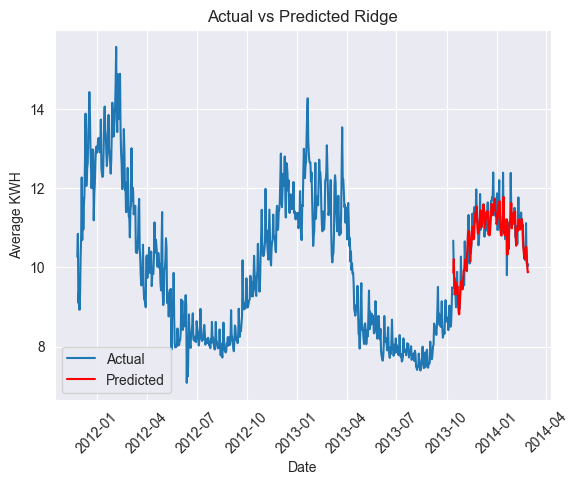

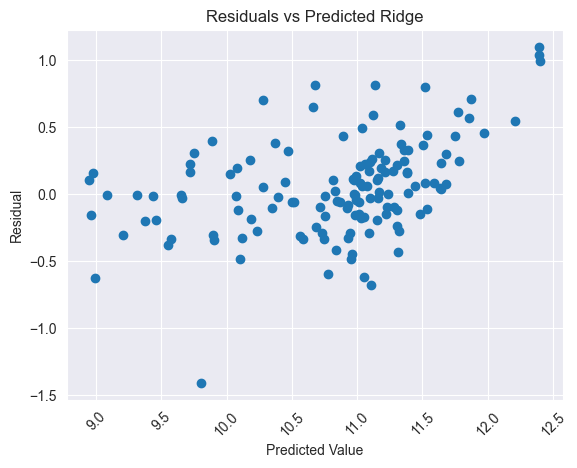

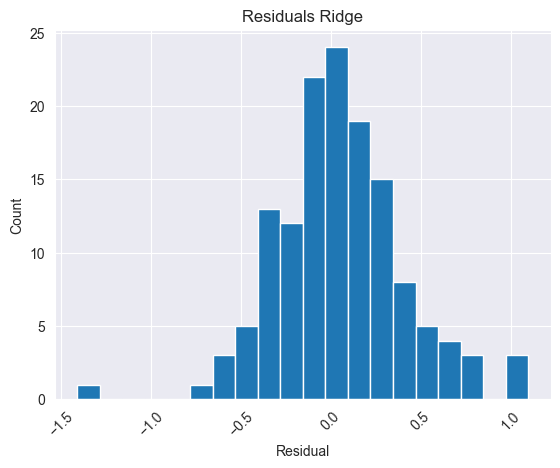

In [506]:
import matplotlib.pyplot as plt

def plot_best_models(model, test_train_splits, model_name):
    result = model.fit(test_train_splits[-1]["train_x"], test_train_splits[-1]["train_y"])
    y_pred = model.predict(test_train_splits[-1]["test_x"])
    y_pred = test_train_splits[-1]["output_encoder"].inverse_transform(y_pred[:,np.newaxis])

    # Plot last test_train_split
    plt.plot(test_train_splits[-1]["train"]["Date"].values, test_train_splits[-1]["train"]["avgKWH"].values) # Plot the train
    plt.plot(test_train_splits[-1]["test"]["Date"].values, y_trues[-1], c="tab:blue", label="Actual")
    plt.plot(test_train_splits[-1]["test"]["Date"].values, y_pred, c="#FF0000", label="Predicted")
    plt.legend(loc="lower left")
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("Average KWH")
    plt.title(f"Actual vs Predicted {model_name}")
    # TODO: Wrap this into the function call to really automate this
    imageSaveDir = '../outputs'
    plt.savefig(Path(f'{imageSaveDir}/Actual vs Predicted {model_name}.png'), format='png',)

    # TODO: add residual plots here as needed
    # # Check if the model returns the resids function so we dont have to calculate it on our own.
    # if hasattr(result, "resid") and callable(result.resid) and hasattr(result, "fittedvalues") and callable(result.fittedvalues, result.resid):
    #     print("debug")
    #     plt.plot(result.fittedvalues, result.resid)
    plt.figure()
    resids = y_trues[-1] - y_pred.flatten(order='c')
    #Predicted vs resids
    plt.scatter(y_trues[-1],resids)
    plt.xticks(rotation=45)
    plt.xlabel("Predicted Value")
    plt.ylabel("Residual")
    plt.title(f"Residuals vs Predicted {model_name}")
    plt.savefig(Path(f'{imageSaveDir}/Residuals vs Predicted {model_name}.png'), format='png',)
    # Residuals distribution
    plt.figure()
    plt.hist(resids, bins = 20)
    plt.xticks(rotation=45)
    plt.xlabel("Residual")
    plt.ylabel("Count")
    plt.title(f"Residuals {model_name}")
    plt.savefig(Path(f'{imageSaveDir}/Residuals {model_name}.png'), format='png',)

plot_best_models(Ridge(), transformed_test_train_splits, model_name="Ridge")

# Base Model
## Base Model Original Data

RMSE: 2.64 MAPE: 0.24


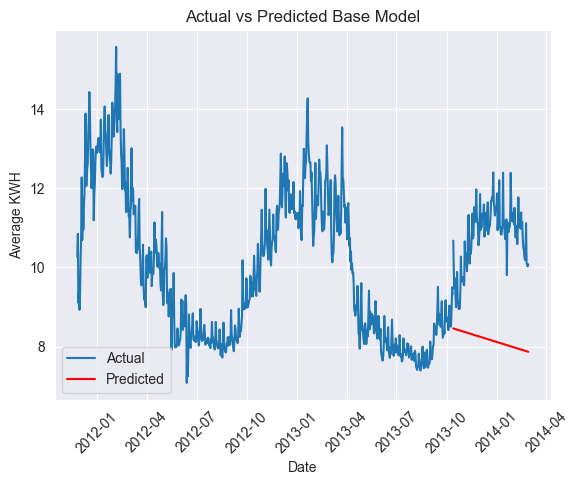

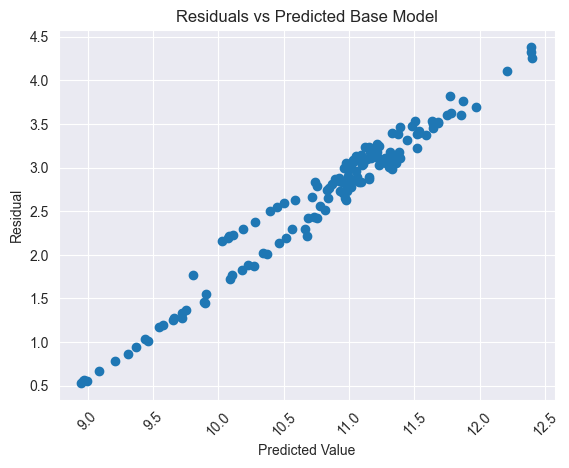

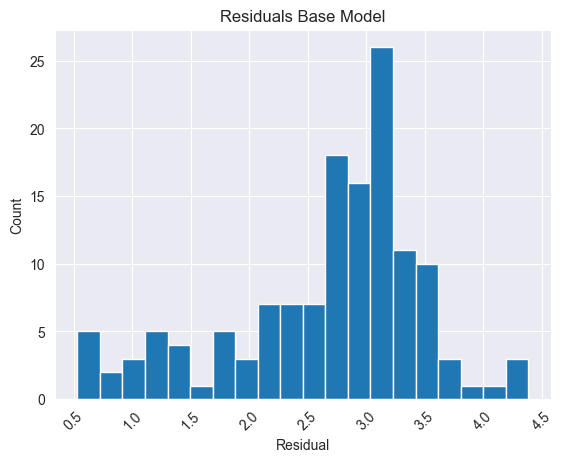

In [507]:
import math
import random
from random import choice
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

# Get test train split with only baseline data
# # Date and KWH data
# baseline_test_train_splits = get_test_train_splits_transformed(test_train_splits, columns=["days_elapsed","(-1)avgKWH", "(-1)SMA3_avgKWH"])
# # # Just Date features
# baseline_test_train_splits = get_test_train_splits_transformed(test_train_splits, columns=["days_elapsed", "weekday sin", "weekday cos", "month sin", "month cos", "Time of Year sin", "Time of Year cos", "season sin", "season cos"])
# days_elapsed model
baseline_test_train_splits = get_test_train_splits_transformed(test_train_splits, columns=["days_elapsed"])
# Train model
rmses, mapes, y_trues, y_preds = evaluate_cross_validation(LinearRegression(), baseline_test_train_splits)
# Plot results
plot_best_models(LinearRegression(), baseline_test_train_splits, "Base Model")
print(f"RMSE: {sum(rmses) / len(rmses):0.2f} MAPE: {sum(mapes) / len(mapes):0.2f}")

## Base Model with Feature Engineering

RMSE: 0.51 MAPE: 0.04


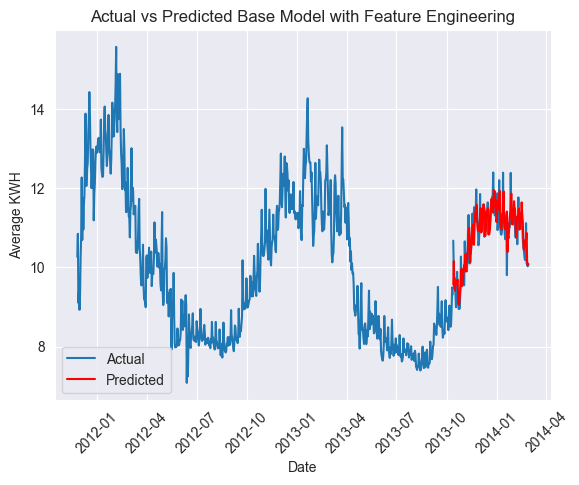

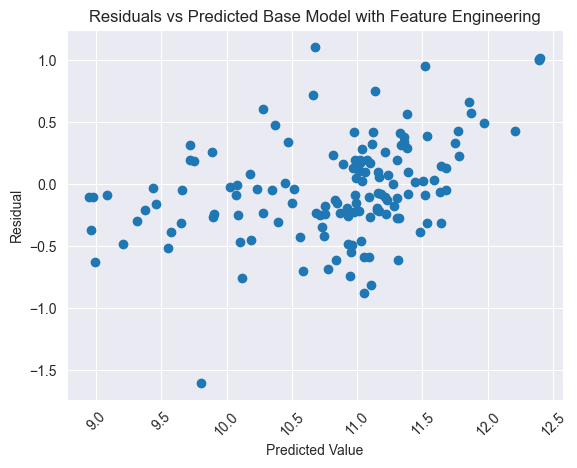

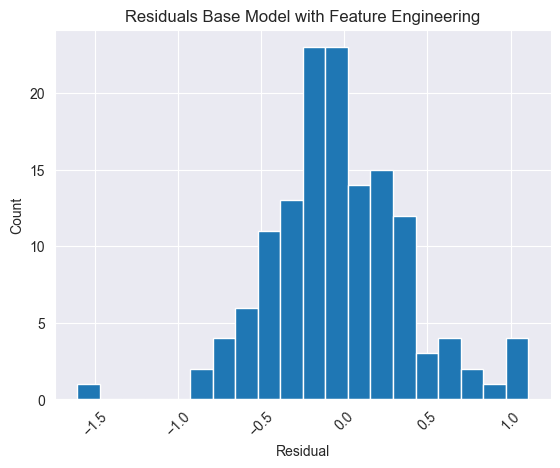

In [508]:
# Get test train split with base-line
baseline_features_test_train_splits = get_test_train_splits_transformed(test_train_splits, columns=["days_elapsed","(-1)avgKWH", "(-1)SMA3_avgKWH", "weekday sin", "weekday cos", "month sin", "month cos", "Time of Year sin", "Time of Year cos", "season sin", "season cos"])
##################
# baseline_features_test_train_splits = get_test_train_splits_transformed(test_train_splits, columns=["days_elapsed","(-1)avgKWH", "(-1)SMA3_avgKWH"])
# baseline_features_test_train_splits = get_test_train_splits_transformed(test_train_splits, columns=["(-1)avgKWH", "(-1)SMA3_avgKWH"])
##################
# Train model
rmses, mapes, y_trues, y_preds = evaluate_cross_validation(LinearRegression(), baseline_features_test_train_splits)
# Plot results
plot_best_models(LinearRegression(), baseline_features_test_train_splits, "Base Model with Feature Engineering")
print(f"RMSE: {sum(rmses) / len(rmses):0.2f} MAPE: {sum(mapes) / len(mapes):0.2f}")

## Base Model with Engineered Features and Complementary Data

RMSE: 1.06 MAPE: 0.09


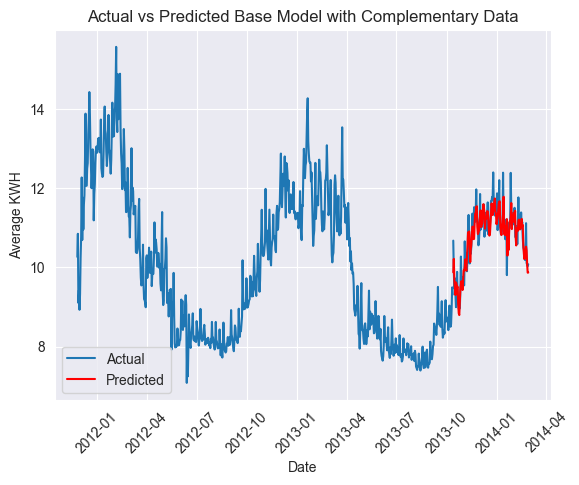

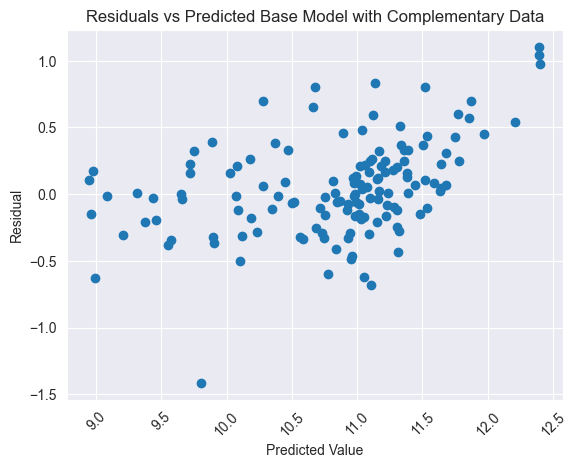

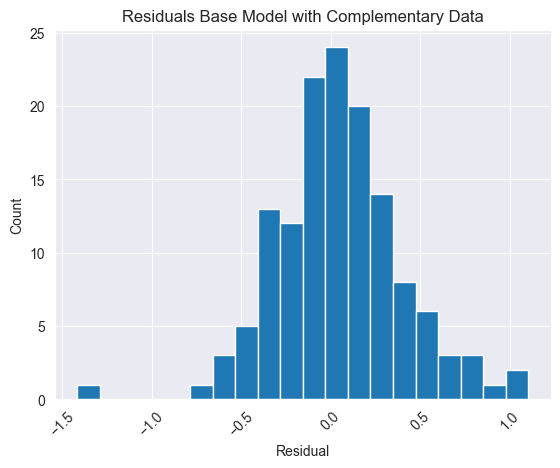

In [509]:
# Get test train split with base-line
baseline_withComp_test_train_splits = get_test_train_splits_transformed(test_train_splits, columns=["days_elapsed","(-1)avgKWH", "(-1)SMA3_avgKWH", "weekday sin", "weekday cos", "month sin", "month cos", "Time of Year sin", "Time of Year cos", "season sin", "season cos","(-1)volume weighted price", "cloud_cover", "sunshine", "global_radiation", "max_temp", "mean_temp", "min_temp", "precipitation", "pressure", "snow_depth"])
# Train model
rmses, mapes, y_trues, y_preds = evaluate_cross_validation(LinearRegression(), baseline_withComp_test_train_splits)
# Plot results
plot_best_models(LinearRegression(), baseline_withComp_test_train_splits, "Base Model with Complementary Data")
print(f"RMSE: {sum(rmses) / len(rmses):0.2f} MAPE: {sum(mapes) / len(mapes):0.2f}")

# Linear Ridge

In [510]:
# Get test train split for all the data (Used for the remainder of the notebook)
all_data_test_train_splits = get_test_train_splits_transformed(test_train_splits, columns=None)

In [511]:
all_data_test_train_splits

[{'train':           Date     avgKWH  cloud_cover  sunshine  global_radiation  max_temp  \
  0   2011-11-26  10.267707          4.0       0.7              24.0      13.9   
  1   2011-11-27  10.850805          3.0       5.9              55.0      13.2   
  2   2011-11-28   9.103382          5.0       0.0              15.0      13.9   
  3   2011-11-29   9.424468          6.0       0.0              15.0      12.8   
  4   2011-11-30   8.931027          4.0       3.7              42.0      11.0   
  ..         ...        ...          ...       ...               ...       ...   
  132 2012-04-06  10.231678          3.0       7.5             185.0      11.2   
  133 2012-04-07   9.861504          7.0       0.1              64.0      14.2   
  134 2012-04-08  10.223994          7.0       0.0              59.0      11.6   
  135 2012-04-09  10.400516          8.0       0.0              59.0      14.8   
  136 2012-04-10   9.529716          2.0       8.3             201.0      14.1   
  
    

In [512]:
import math
import random
from random import choice

RANDOM_SAMPLES = 30
tests = {} # (alpha) => (avg mape, avg, rmse)

ALPHAS = [10_000, 5_000, 1_000, 500.0, 100.0, 50.0, 10.0, 5.0, 1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

random.seed(42)
np.random.seed(42)
for alpha in ALPHAS:
    k = (alpha)
    if k in tests:
        continue

    mlp_model = Ridge(alpha)
    rmses, mapes, y_trues, y_preds = evaluate_cross_validation(mlp_model, all_data_test_train_splits)
    avg_mape = sum(mapes) / len(mapes)
    avg_rmse = sum(rmses) / len(rmses)
    tests[k] = (avg_mape, avg_rmse)
    
    print(f"(alpha={alpha}) => (MAPE={avg_mape}, RMSE={avg_rmse})")

(alpha=10000) => (MAPE=0.16356337151179134, RMSE=1.5739975229405838)
(alpha=5000) => (MAPE=0.1377485638635032, RMSE=1.3344271462723623)
(alpha=1000) => (MAPE=0.06964718824030358, RMSE=0.7110824220324394)
(alpha=500.0) => (MAPE=0.047836339424729576, RMSE=0.5233953680011152)
(alpha=100.0) => (MAPE=0.0449328557820522, RMSE=0.5122901791355872)
(alpha=50.0) => (MAPE=0.05540508946124136, RMSE=0.6115779583961322)
(alpha=10.0) => (MAPE=0.07529471286722347, RMSE=0.8021998060252754)
(alpha=5.0) => (MAPE=0.0809061117646755, RMSE=0.8559037065182183)
(alpha=1.0) => (MAPE=0.08439929584250813, RMSE=0.8898623312234403)
(alpha=0.5) => (MAPE=0.07890869688547618, RMSE=0.8446534326682311)
(alpha=0.1) => (MAPE=0.0681742759377703, RMSE=0.770509270618623)
(alpha=0.05) => (MAPE=0.07390996045278556, RMSE=0.8590116680498563)
(alpha=0.01) => (MAPE=0.08496021538360539, RMSE=1.007205936706854)
(alpha=0.005) => (MAPE=0.08707011233351376, RMSE=1.0326651883251254)
(alpha=0.001) => (MAPE=0.08891617868682747, RMSE=1.05

In [513]:
rows = [{'alpha': k, 'mape': v[0], 'rmse': v[1]} for k,v in tests.items()]
hp_df = pd.DataFrame(rows)
best_ridge = hp_df[hp_df["rmse"] == hp_df["rmse"].min()]
best_ridge

,alpha,mape,rmse
4,100.0,0.044933,0.51229


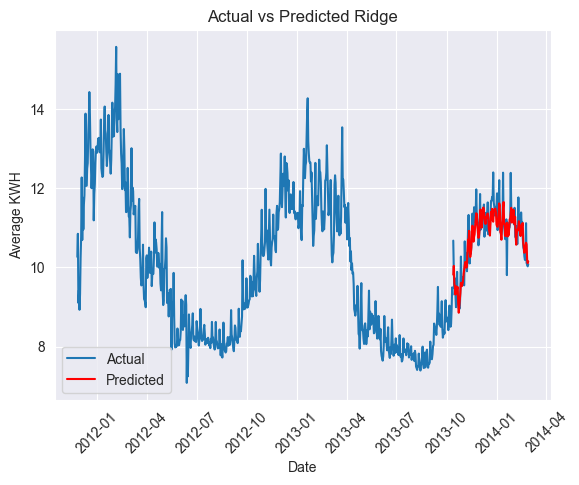

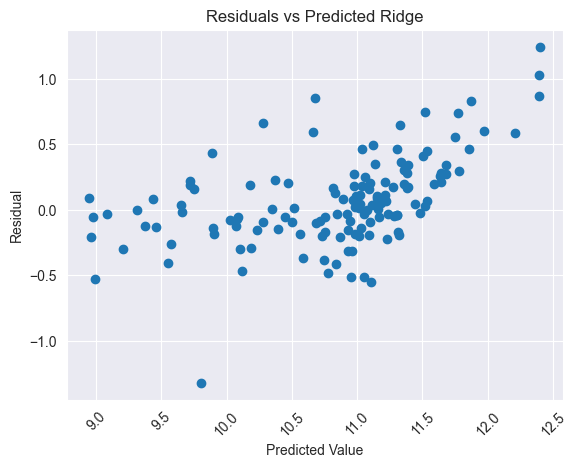

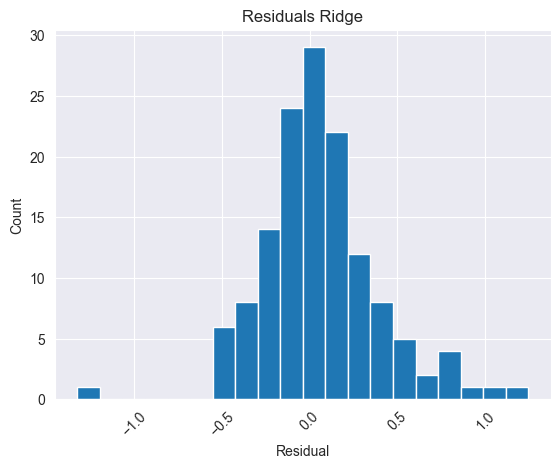

In [514]:
plot_best_models(Ridge(best_ridge['alpha'].values[0]), all_data_test_train_splits, "Ridge")

# Linear Lasso

In [515]:
RANDOM_SAMPLES = 30
tests = {} # (alpha) => (avg mape, avg, rmse)

ALPHAS = [10_000, 5_000, 1_000, 500.0, 100.0, 50.0, 10.0, 5.0, 1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

random.seed(42)
np.random.seed(42)
for alpha in ALPHAS:
    k = (alpha)
    if k in tests:
        continue

    mlp_model = Lasso(alpha)
    rmses, mapes, y_trues, y_preds = evaluate_cross_validation(mlp_model, all_data_test_train_splits)
    avg_mape = sum(mapes) / len(mapes)
    avg_rmse = sum(rmses) / len(rmses)
    tests[k] = (avg_mape, avg_rmse)

    print(f"(alpha={alpha}) => (MAPE={avg_mape}, RMSE={avg_rmse})")

(alpha=10000) => (MAPE=0.20669830497343544, RMSE=1.9865213937748485)
(alpha=5000) => (MAPE=0.20669830497343544, RMSE=1.9865213937748485)
(alpha=1000) => (MAPE=0.20669830497343544, RMSE=1.9865213937748485)
(alpha=500.0) => (MAPE=0.20669830497343544, RMSE=1.9865213937748485)
(alpha=100.0) => (MAPE=0.20669830497343544, RMSE=1.9865213937748485)
(alpha=50.0) => (MAPE=0.20669830497343544, RMSE=1.9865213937748485)
(alpha=10.0) => (MAPE=0.20669830497343544, RMSE=1.9865213937748485)
(alpha=5.0) => (MAPE=0.20669830497343544, RMSE=1.9865213937748485)
(alpha=1.0) => (MAPE=0.20669830497343544, RMSE=1.9865213937748485)
(alpha=0.5) => (MAPE=0.11888712174732312, RMSE=1.167505399826724)
(alpha=0.1) => (MAPE=0.03481005624241371, RMSE=0.4155265104072107)
(alpha=0.05) => (MAPE=0.03181231187882657, RMSE=0.3830730242001106)
(alpha=0.01) => (MAPE=0.05970701916509068, RMSE=0.6394150741202069)
(alpha=0.005) => (MAPE=0.07269552203746941, RMSE=0.7562320934475415)
(alpha=0.001) => (MAPE=0.06887223423096615, RMSE=

In [516]:
rows = [{'alpha': k, 'mape': v[0], 'rmse': v[1]} for k,v in tests.items()]
hp_df = pd.DataFrame(rows)
best_lasso = hp_df[hp_df["rmse"] == hp_df["rmse"].min()]
best_lasso

,alpha,mape,rmse
11,0.05,0.031812,0.383073


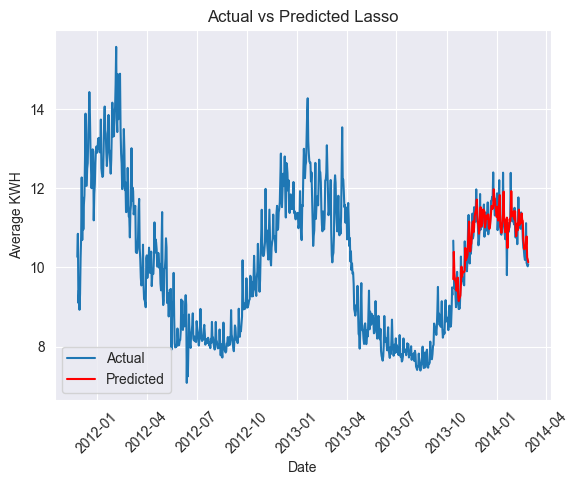

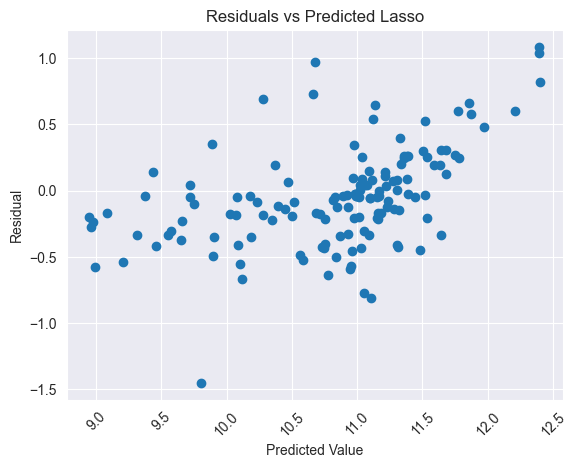

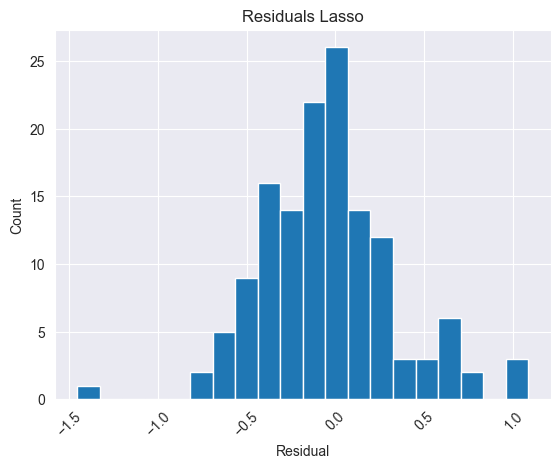

In [517]:
plot_best_models(Lasso(best_lasso['alpha'].values[0]), all_data_test_train_splits, "Lasso")

# MLP

In [518]:
def scaled_random_range(min=2, max=64):
    min_log = math.log(min, 2)
    max_log = math.log(max, 2)

    rand_log = min_log + (random.random() * (max_log - min_log))
    rand = math.pow(2, rand_log)
    return rand

RANDOM_SAMPLES = 30
tests = {} # (layer_1, layer_2, activation) => (avg mape, avg, rmse)

random.seed(42)
np.random.seed(42)
for i in range(RANDOM_SAMPLES):
    layer_1 = int(scaled_random_range(1, 128))
    layer_2 = int(scaled_random_range(1, 128))
    activation_func = choice(["relu", "tanh", "logistic"])

    k = (layer_1, layer_2, activation_func)
    if k in tests:
        continue

    mlp_model = MLPRegressor(hidden_layer_sizes=(layer_1, layer_2), activation=activation_func, early_stopping=True, max_iter=10_000)
    rmses, mapes, y_trues, y_preds = evaluate_cross_validation(mlp_model, all_data_test_train_splits)
    avg_mape = sum(mapes) / len(mapes)
    avg_rmse = sum(rmses) / len(rmses)
    tests[k] = (avg_mape, avg_rmse)
    
    print(f"Sample {i} (layer_1={layer_1}, layer_2={layer_2}, activation={activation_func}) => (MAPE={avg_mape}, RMSE={avg_rmse})")

Sample 0 (layer_1=22, layer_2=1, activation=tanh) => (MAPE=0.13452213136788846, RMSE=1.3395707431496873)
Sample 1 (layer_1=3, layer_2=1, activation=relu) => (MAPE=0.14312846164251133, RMSE=1.3457831533400635)
Sample 2 (layer_1=26, layer_2=75, activation=relu) => (MAPE=0.0652251599785453, RMSE=0.7428116339923809)
Sample 3 (layer_1=17, layer_2=1, activation=relu) => (MAPE=0.06739935151835028, RMSE=0.7983762157615437)
Sample 4 (layer_1=2, layer_2=11, activation=relu) => (MAPE=0.06288633998132406, RMSE=0.7538541265808132)
Sample 5 (layer_1=15, layer_2=32, activation=logistic) => (MAPE=0.0643477476426769, RMSE=0.7263228827890449)
Sample 6 (layer_1=14, layer_2=2, activation=logistic) => (MAPE=0.09820838283015224, RMSE=0.9787609159420528)
Sample 7 (layer_1=3, layer_2=67, activation=relu) => (MAPE=0.059390670625751985, RMSE=0.7059380543869164)
Sample 8 (layer_1=29, layer_2=5, activation=relu) => (MAPE=0.09119779420287452, RMSE=1.0169520850176799)
Sample 9 (layer_1=2, layer_2=40, activation=rel

In [519]:
rows = [{'layer_1': k[0], 'layer_2': k[1], 'activation': k[2], 'mape': v[0], 'rmse': v[1]} for k,v in tests.items()]
hp_df = pd.DataFrame(rows)
best_mlp = hp_df[hp_df["rmse"] == hp_df["rmse"].min()]
best_mlp
# best_mlp['layer_1'].values[0]

,layer_1,layer_2,activation,mape,rmse
14,20,65,logistic,0.029718,0.369101


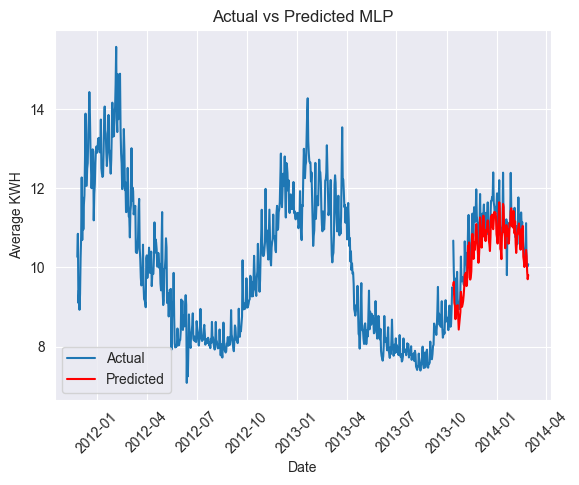

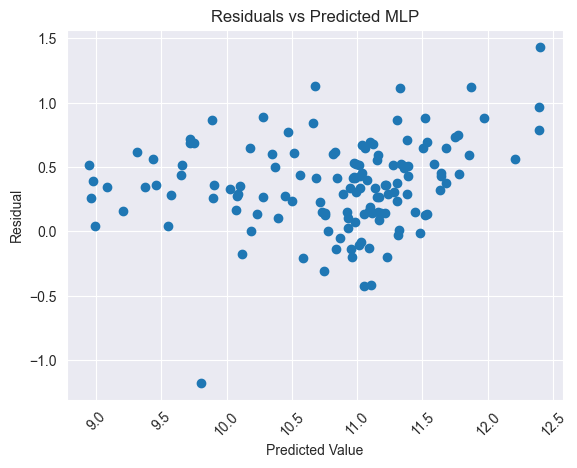

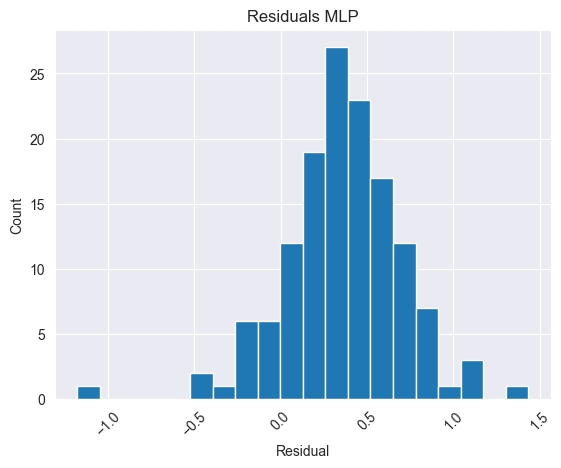

In [520]:
plot_best_models(MLPRegressor(hidden_layer_sizes=(best_mlp['layer_1'].values[0], best_mlp['layer_2'].values[0]),
                              activation='logistic', early_stopping=True, max_iter=10_000), all_data_test_train_splits, "MLP")